In [1]:
import re
import os
import time
import keras
import glob
import nltk
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split  
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from keras.layers import LSTM,GRU,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D,Conv1D,SpatialDropout1D,MaxPooling1D



In [2]:
df = pd.read_excel('/kaggle/input/bangla-sentiment-analysis/Sentiment Analysis Bangla.xlsx')
df.head()

,comment,Category,Gender,comment react number,label
0,হয়তো আয়মান ভাইয়ের পেইজের এডমিন মুনজেরিন আপু। আ...,Social,Female,340.0,troll
1,এতো আমাদের জন্য বড় আনন্দের সংবাদ,Social,Male,264.0,troll
2,এজন্যই বলি আ-লীগে চলে আসুন। সব নির্বাচন-ই সুষ্...,Politician,Male,8.0,not bully
3,এটিএম কার্ড দেখিয়ে স্টুডেন্ট হাফপাস নেওয়া আমি,Social,Male,4.0,troll
4,আমাদের জীবনে কোম সিজি নাই,Social,Male,1.0,troll


In [3]:
df = df.loc[:,['comment','label']]
df.head()

,comment,label
0,হয়তো আয়মান ভাইয়ের পেইজের এডমিন মুনজেরিন আপু। আ...,troll
1,এতো আমাদের জন্য বড় আনন্দের সংবাদ,troll
2,এজন্যই বলি আ-লীগে চলে আসুন। সব নির্বাচন-ই সুষ্...,not bully
3,এটিএম কার্ড দেখিয়ে স্টুডেন্ট হাফপাস নেওয়া আমি,troll
4,আমাদের জীবনে কোম সিজি নাই,troll


In [5]:
df['label'] = df['label'].replace({'not bully': 'normal', 'religios': 'religious', 'trol': 'troll', 'trolll': 'troll'})


In [5]:
df=pd.read_excel('/kaggle/input/bangla-sentiment-analysis/Sentiment Analysis Bangla.xlsx')
df.head()

,comment,Category,Gender,comment react number,label
0,হয়তো আয়মান ভাইয়ের পেইজের এডমিন মুনজেরিন আপু। আ...,Social,Female,340.0,troll
1,এতো আমাদের জন্য বড় আনন্দের সংবাদ,Social,Male,264.0,troll
2,এজন্যই বলি আ-লীগে চলে আসুন। সব নির্বাচন-ই সুষ্...,Politician,Male,8.0,not bully
3,এটিএম কার্ড দেখিয়ে স্টুডেন্ট হাফপাস নেওয়া আমি,Social,Male,4.0,troll
4,আমাদের জীবনে কোম সিজি নাই,Social,Male,1.0,troll


In [6]:
df.shape

(49999, 5)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   comment               49999 non-null  object 
 1   Category              49999 non-null  object 
 2   Gender                49999 non-null  object 
 3   comment react number  49994 non-null  float64
 4   label                 49999 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.9+ MB


In [8]:
df.isna().sum()

comment                 0
Category                0
Gender                  0
comment react number    5
label                   0
dtype: int64

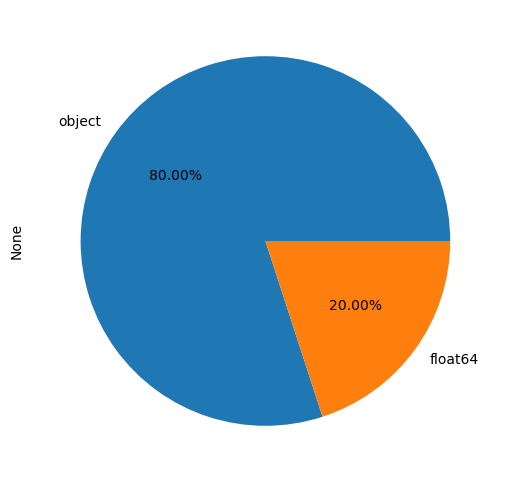

In [9]:
plt.figure(figsize=(6,6))
df.dtypes.value_counts().plot.pie(autopct='%0.2f%%')
plt.show()

In [10]:
df['Gender'].value_counts()

Female    30462
Male      19536
m             1
Name: Gender, dtype: int64

In [11]:


r=df.loc[df['Gender']=='m']
r

,comment,Category,Gender,comment react number,label
48901,শুভকামনা রইল মেহজাবীন আপু।,actor,m,119.0,not bully


In [12]:

df.Gender=df['Gender'].replace(to_replace="m",
           value="Female")

In [13]:
df.Gender.value_counts()

Female    30463
Male      19536
Name: Gender, dtype: int64

In [14]:
newdata = df.groupby('Gender').size().rename_axis('Gender').reset_index(name='Count')
newdata.head()

,Gender,Count
0,Female,30463
1,Male,19536


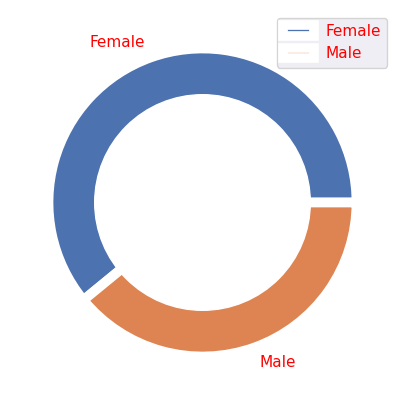

In [15]:
labels = newdata.Gender
values = newdata.Count
plt.figure(figsize=(5,5))
sns.set()
my_circle = plt.Circle( (0,0), 0.7, color='white')
plt.rcParams['text.color'] = 'red'
plt.pie(values, labels=labels, wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
plt.legend(loc='upper right')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

<AxesSubplot:xlabel='Gender', ylabel='count'>

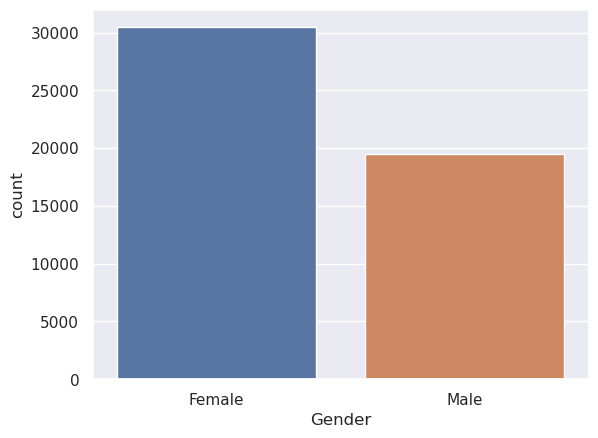

In [16]:

sns.countplot(x='Gender',data=df)

In [17]:


df.Category.value_counts()

Actor         28467
Social         9876
Singer         3367
Politician     2847
Sports         2784
sports          744
politician      716
social          684
actor           427
sport            68
actors           18
spors             1
Name: Category, dtype: int64

In [18]:
df.Category=df['Category'].replace(to_replace=["actors",'actors','actor'],
           value="Actor")
df.Category=df['Category'].replace(to_replace='politician',
           value="Politician")
df.Category=df['Category'].replace(to_replace=["sports",'sport','spors'],
           value="Sports")
df.Category=df['Category'].replace(to_replace='social',
           value="Social")
df.Category.value_counts()

Actor         28912
Social        10560
Sports         3597
Politician     3563
Singer         3367
Name: Category, dtype: int64

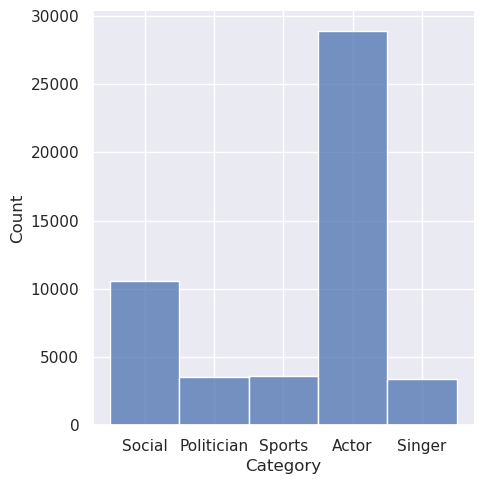

In [20]:
sns.displot(df.Category)

In [21]:
df.rename(columns = {'comment react number':'react_number','label':'sentiment'}, inplace = True)
df.sentiment.value_counts()

not bully    18239
troll        12727
sexual        9098
religious     7831
threat        2084
religios        16
trol             3
trolll           1
Name: sentiment, dtype: int64

In [22]:
df.sentiment=df['sentiment'].replace(to_replace=["trol",'trolll'],
           value="troll")
df.sentiment=df['sentiment'].replace(to_replace='religios',
           value="religious")
df.sentiment.value_counts()


not bully    18239
troll        12731
sexual        9098
religious     7847
threat        2084
Name: sentiment, dtype: int64

In [23]:
data={'class':['not bully','troll ','sexual','religious','threat'],
'value':[18239,12731,9098,7847,2084]}
df2=pd.DataFrame(data)
fig=px.pie(df2,values='value',names='class',hole=0.5,color='class')
fig.update_traces(textinfo='label+percent', insidetextfont=dict(color="blue"))
fig.show()

In [24]:

fig = px.scatter_polar(df, r="sentiment", theta="react_number",color='Gender')
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            tickfont=dict(
                color='indigo'
            )
        )
    )
)
fig.show()

In [25]:
fig = px.scatter_polar(df, r="Category", theta="sentiment",color='Gender')
fig.show()

In [26]:
fig = px.line_polar(df, r="Gender", theta="sentiment", color="Category", line_close=True,
                    color_discrete_sequence=px.colors.sequential.Plasma_r,
                    template="plotly_dark",)
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            tickfont=dict(
                color='goldenrod'
            )
        )
    )
)
fig.show()

In [27]:

df.react_number.value_counts()

0.0      29265
1.0      10486
2.0       3670
3.0       1815
4.0       1118
         ...  
236.0        1
139.0        1
97.0         1
135.0        1
199.0        1
Name: react_number, Length: 200, dtype: int64

In [28]:
df.react_number=df.react_number.fillna('0')
df.isna().sum()

comment         0
Category        0
Gender          0
react_number    0
sentiment       0
dtype: int64

In [43]:
df.sentiment.nunique()

5

In [30]:
data = df
comments = data['comment']
labels = data['sentiment']

In [42]:
data.shape

(49999, 5)

In [41]:
labels.shape

(49999,)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(comments, labels, test_size=0.2, random_state=42)

NameError: name 'comments' is not defined

In [40]:
X_train.shape

(39999, 64)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()

# Fit and transform the categorical variable
encoded = le.fit_transform(df['sentiment'])

print(encoded)
# Print the class labels and their corresponding integer codes
print("Class Labels: ", le.classes_)
print("Integer Codes: ", le.transform(le.classes_))

In [ ]:
df['label']=encoded
df.head()

In [3]:
df = df.loc[:,['comment','label']]
df.head()

NameError: name 'df' is not defined

In [28]:
# from bnlp import BasicTokenizer
# basic_t = BasicTokenizer()
# raw_text = "আমি বাংলায় গান গাই।"
# tokens = basic_t.tokenize(raw_text)
# print(tokens)

In [29]:
!pip install bnlp
!pip install bnlp_toolkit

  Preparing metadata (setup.py) ... done
  Created wheel for bnlp: filename=bnlp-0.8-py3-none-any.whl size=32827 sha256=d36a649ecabda14f175444484e6dbebaba985e12e54d97dbae2fe2d0986a0d7a
  Stored in directory: /root/.cache/pip/wheels/31/d5/bd/2c222809c6b416fca8a04d6c28286029507bedb6164ca59257
Successfully built bnlp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 966.9/966.9 kB 24.1 MB/s eta 0:00:0000:01
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=620de90715e0776388d3c1a301e31143b27d1b0f3030d806fbd7ecd9c71bf98b
  Stored in directory: /root/.cache/pip/wheels/b9/c6/29/f04340b92ea4bc94de18767d2a215768a86e7115ac471ca82e
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.2.0
    Uninstalling emoji-2.2.0:
      Succ

In [30]:

from bnlp.corpus import stopwords, punctuations, letters, digits

print(stopwords)
print(punctuations)
print(letters)
print(digits)

['অতএব', 'অথচ', 'অথবা', 'অনুযায়ী', 'অনেক', 'অনেকে', 'অনেকেই', 'অন্তত', 'অন্য', 'অবধি', 'অবশ্য', 'অর্থাত', 'আই', 'আগামী', 'আগে', 'আগেই', 'আছে', 'আজ', 'আদ্যভাগে', 'আপনার', 'আপনি', 'আবার', 'আমরা', 'আমাকে', 'আমাদের', 'আমার', 'আমি', 'আর', 'আরও', 'ই', 'ইত্যাদি', 'ইহা', 'উচিত', 'উত্তর', 'উনি', 'উপর', 'উপরে', 'এ', 'এঁদের', 'এঁরা', 'এই', 'একই', 'একটি', 'একবার', 'একে', 'এক্', 'এখন', 'এখনও', 'এখানে', 'এখানেই', 'এটা', 'এটাই', 'এটি', 'এত', 'এতটাই', 'এতে', 'এদের', 'এব', 'এবং', 'এবার', 'এমন', 'এমনকী', 'এমনি', 'এর', 'এরা', 'এল', 'এস', 'এসে', 'ঐ', 'ও', 'ওঁদের', 'ওঁর', 'ওঁরা', 'ওই', 'ওকে', 'ওখানে', 'ওদের', 'ওর', 'ওরা', 'কখনও', 'কত', 'কবে', 'কমনে', 'কয়েক', 'কয়েকটি', 'করছে', 'করছেন', 'করতে', 'করবে', 'করবেন', 'করলে', 'করলেন', 'করা', 'করাই', 'করায়', 'করার', 'করি', 'করিতে', 'করিয়া', 'করিয়ে', 'করে', 'করেই', 'করেছিলেন', 'করেছে', 'করেছেন', 'করেন', 'কাউকে', 'কাছ', 'কাছে', 'কাজ', 'কাজে', 'কারও', 'কারণ', 'কি', 'কিংবা', 'কিছু', 'কিছুই', 'কিন্তু', 'কী', 'কে', 'কেউ', 'কেউই', 'কেখা', 'কেন', 'কোটি', 'কোন', 'কোনও'

In [31]:
import re
from bnlp import NLTKTokenizer
from bnlp.corpus import stopwords
from bnlp.corpus import stopwords, punctuations, letters, digits

# define the preprocessing function
def preprocess_bangla_text(text):
   
    # tokenize text
    tokenizer = NLTKTokenizer()
    text_tokens = tokenizer.word_tokenize(text)
    # remove punctuations
    text = [token for token in text_tokens if token not in punctuations]
    # remove stopwords
    stop_words = set(stopwords)
    text_tokens = [token for token in text_tokens if token not in stop_words]
    # join tokens back into a single string
    text = " ".join(text_tokens)
    # remove any remaining extra spaces
    text = re.sub(" +", " ", text)
    return text

# apply the preprocessing function to the 'comment' column
df['comment'] = df['comment'].apply(preprocess_bangla_text)

In [32]:
# def text_to_word_list(text):
#     text=text.split()
#     return text

# def replace_strings(text):
#     emoji_pattern = re.compile("["
#                            u"\U0001F600-\U0001F64F"  
#                            u"\U0001F300-\U0001F5FF"  
#                            u"\U0001F680-\U0001F6FF"  
#                            u"\U0001F1E0-\U0001F1FF"  
#                            u"\U00002702-\U000027B0"
#                            u"\U000024C2-\U0001F251"
#                            u"\u00C0-\u017F"          
#                            u"\u2000-\u206F"       
                               
#                            "]+", flags=re.UNICODE)
#     english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    
#     text=emoji_pattern.sub(r'', text)
#     text=english_pattern.sub(r'', text)

#     return text
# def remove_punctuations(srt):
#     punct='''```   `  £|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰⚽️✌�❤️☺♥️π!'''
#     no_punct=""
#     for char in srt:
#         if char not in punct:
#             no_punct=no_punct + char
#     return no_punct
# stop_words = {'অতএব', 'অথচ', 'অথবা', 'অনুযায়ী', 'অনেক', 'অনেকে', 'অনেকেই', 'অন্তত', 'অন্য', 'অবধি', 'অবশ্য', 'অর্থাত', 'আই', 'আগামী', 'আগে', 'আগেই', 'আছে', 'আজ', 'আদ্যভাগে', 'আপনার', 'আপনি', 'আবার', 'আমরা', 'আমাকে', 'আমাদের', 'আমার', 'আমি', 'আর', 'আরও', 'ই', 'ইত্যাদি', 'ইহা', 'উচিত', 'উত্তর', 'উনি', 'উপর', 'উপরে', 'এ', 'এঁদের', 'এঁরা', 'এই', 'একই', 'একটি', 'একবার', 'একে', 'এক্', 'এখন', 'এখনও', 'এখানে', 'এখানেই', 'এটা', 'এটাই', 'এটি', 'এত', 'এতটাই', 'এতে', 'এদের', 'এব', 'এবং', 'এবার', 'এমন', 'এমনকী', 'এমনি', 'এর', 'এরা', 'এল', 'এস', 'এসে', 'ঐ', 'ও', 'ওঁদের', 'ওঁর', 'ওঁরা', 'ওই', 'ওকে', 'ওখানে', 'ওদের', 'ওর', 'ওরা', 'কখনও', 'কত', 'কবে', 'কমনে', 'কয়েক', 'কয়েকটি', 'করছে', 'করছেন', 'করতে', 'করবে', 'করবেন', 'করলে', 'করলেন', 'করা', 'করাই', 'করায়', 'করার', 'করি', 'করিতে', 'করিয়া', 'করিয়ে', 'করে', 'করেই', 'করেছিলেন', 'করেছে', 'করেছেন', 'করেন', 'কাউকে', 'কাছ', 'কাছে', 'কাজ', 'কাজে', 'কারও', 'কারণ', 'কি', 'কিংবা', 'কিছু', 'কিছুই', 'কিন্তু', 'কী', 'কে', 'কেউ', 'কেউই', 'কেখা', 'কেন', 'কোটি', 'কোন', 'কোনও', 'কোনো', 'ক্ষেত্রে', 'কয়েক', 'খুব', 'গিয়ে', 'গিয়েছে', 'গিয়ে', 'গুলি', 'গেছে', 'গেল', 'গেলে', 'গোটা', 'চলে', 'চান', 'চায়', 'চার', 'চালু', 'চেয়ে', 'চেষ্টা', 'ছাড়া', 'ছাড়াও', 'ছিল', 'ছিলেন', 'জন', 'জনকে', 'জনের', 'জন্য', 'জন্যওজে', 'জানতে', 'জানা', 'জানানো', 'জানায়', 'জানিয়ে', 'জানিয়েছে', 'জে', 'জ্নজন', 'টি', 'ঠিক', 'তখন', 'তত', 'তথা', 'তবু', 'তবে', 'তা', 'তাঁকে', 'তাঁদের', 'তাঁর', 'তাঁরা', 'তাঁাহারা', 'তাই', 'তাও', 'তাকে', 'তাতে', 'তাদের', 'তার', 'তারপর', 'তারা', 'তারৈ', 'তাহলে', 'তাহা', 'তাহাতে', 'তাহার', 'তিনঐ', 'তিনি', 'তিনিও', 'তুমি', 'তুলে', 'তেমন', 'তো', 'তোমার', 'থাকবে', 'থাকবেন', 'থাকা', 'থাকায়', 'থাকে', 'থাকেন', 'থেকে', 'থেকেই', 'থেকেও', 'দিকে', 'দিতে', 'দিন', 'দিয়ে', 'দিয়েছে', 'দিয়েছেন', 'দিলেন', 'দু', 'দুই', 'দুটি', 'দুটো', 'দেওয়া', 'দেওয়ার', 'দেওয়া', 'দেখতে', 'দেখা', 'দেখে', 'দেন', 'দেয়', 'দ্বারা', 'ধরা', 'ধরে', 'ধামার', 'নতুন', 'নয়', 'না', 'নাই', 'নাকি', 'নাগাদ', 'নানা', 'নিজে', 'নিজেই', 'নিজেদের', 'নিজের', 'নিতে', 'নিয়ে', 'নিয়ে', 'নেই', 'নেওয়া', 'নেওয়ার', 'নেওয়া', 'নয়', 'পক্ষে', 'পর', 'পরে', 'পরেই', 'পরেও', 'পর্যন্ত', 'পাওয়া', 'পাচ', 'পারি', 'পারে', 'পারেন', 'পি', 'পেয়ে', 'পেয়্র্', 'প্রতি', 'প্রথম', 'প্রভৃতি', 'প্রযন্ত', 'প্রাথমিক', 'প্রায়', 'প্রায়', 'ফলে', 'ফিরে', 'ফের', 'বক্তব্য', 'বদলে', 'বন', 'বরং', 'বলতে', 'বলল', 'বললেন', 'বলা', 'বলে', 'বলেছেন', 'বলেন', 'বসে', 'বহু', 'বা', 'বাদে', 'বার', 'বি', 'বিনা', 'বিভিন্ন', 'বিশেষ', 'বিষয়টি', 'বেশ', 'বেশি', 'ব্যবহার', 'ব্যাপারে', 'ভাবে', 'ভাবেই', 'মতো', 'মতোই', 'মধ্যভাগে', 'মধ্যে', 'মধ্যেই', 'মধ্যেও', 'মনে', 'মাত্র', 'মাধ্যমে', 'মোট', 'মোটেই', 'যখন', 'যত', 'যতটা', 'যথেষ্ট', 'যদি', 'যদিও', 'যা', 'যাঁর', 'যাঁরা', 'যাওয়া', 'যাওয়ার', 'যাওয়া', 'যাকে', 'যাচ্ছে', 'যাতে', 'যাদের', 'যান', 'যাবে', 'যায়', 'যার', 'যারা', 'যিনি', 'যে', 'যেখানে', 'যেতে', 'যেন', 'যেমন', 'র', 'রকম', 'রয়েছে', 'রাখা', 'রেখে', 'লক্ষ', 'শুধু', 'শুরু', 'সঙ্গে', 'সঙ্গেও', 'সব', 'সবার', 'সমস্ত', 'সম্প্রতি', 'সহ', 'সহিত', 'সাধারণ', 'সামনে', 'সি', 'সুতরাং', 'সে', 'সেই', 'সেখান', 'সেখানে', 'সেটা', 'সেটাই', 'সেটাও', 'সেটি', 'স্পষ্ট', 'স্বয়ং', 'হইতে', 'হইবে', 'হইয়া', 'হওয়া', 'হওয়ায়', 'হওয়ার', 'হচ্ছে', 'হত', 'হতে', 'হতেই', 'হন', 'হবে', 'হবেন', 'হয়', 'হয়তো', 'হয়নি', 'হয়ে', 'হয়েই', 'হয়েছিল', 'হয়েছে', 'হয়েছেন', 'হল', 'হলে', 'হলেই', 'হলেও', 'হলো', 'হাজার', 'হিসাবে', 'হৈলে', 'হোক', 'হয়'}

# def remove_stop_words(text):
#     text = [w for w in text if not w in stop_words]
#     text = ' '.join(text)
#     return text
# def preprocessing(text):
#     #rs=text_to_word_list(text)
#     #rs=replace_strings(rs)
#     rs=remove_punctuations(replace_strings(text))
#     rs=remove_stop_words(rs)
#     return rs

In [33]:
# df['comment']=df.comment.apply(lambda x: preprocessing(str(x)))

In [7]:

 df.reset_index(drop=True,inplace=True)

In [8]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df['sentiment']= label_encoder.fit_transform(df['label'])

In [9]:
train1, test1 = train_test_split(df,random_state=42, test_size=0.2)
training_sentences = []
testing_sentences = []



train_sentences=train1['comment'].values
train_labels=train1['sentiment'].values
for i in range(train_sentences.shape[0]): 
    #print(train_sentences[i])
    x=str(train_sentences[i])
    training_sentences.append(x)
    
training_sentences=np.array(training_sentences)





test_sentences=test1['comment'].values
test_labels=test1['sentiment'].values

for i in range(test_sentences.shape[0]): 
    x=str(test_sentences[i])
    testing_sentences.append(x)
    
testing_sentences=np.array(testing_sentences)


train_labels=keras.utils.to_categorical(train_labels)


test_labels=keras.utils.to_categorical(test_labels)
print("Training Set Length: "+str(len(train1)))
print("Testing Set Length: "+str(len(test1)))
print("training_sentences shape: "+str(training_sentences.shape))
print("testing_sentences shape: "+str(testing_sentences.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))

Training Set Length: 39999
Testing Set Length: 10000
training_sentences shape: (39999,)
testing_sentences shape: (10000,)
train_labels shape: (39999, 5)
test_labels shape: (10000, 5)


In [10]:
print(training_sentences[1])
print(train_labels[0])

জায়েদ খান এটা কীসের হিরো সাজে সবার সাথে বেয়াদবি করে।আজকে ও দেখালাম আগেও দেখলাম মৌসুমীর সাথে করছে।
[0. 0. 0. 0. 1.]


In [11]:

embedding_dim =300
max_length =256
trunc_type='post'

oov_tok = "<OOV>"
vocab_size = 1500

In [39]:
# from transformers import AutoTokenizer, AutoModel
# import torch
# import requests
# from bs4 import BeautifulSoup
# import re

# model_name = "sagorsarker/bangla-bert-base" 


# # Download pytorch model
# model = AutoModel.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)

#model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [12]:


tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(training_sentences)

padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)
test_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

65242
Word index length:65242


In [13]:
padded

array([[  0,   0,   0, ...,   1, 812,   1],
       [  0,   0,   0, ...,   1,  70, 951],
       [  0,   0,   0, ..., 236,   3,   1],
       ...,
       [  0,   0,   0, ...,   1,  17,   1],
       [  0,   0,   0, ...,   1,   1,   1],
       [  0,   0,   0, ..., 119,   4,   1]], dtype=int32)

In [14]:
print("Sentence :--> \n")
print(training_sentences[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[2])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[2])

Sentence :--> 

ওরে রোজার মাস ছবিটা চেঞ্জ কর রাতে ঘুম আসে নারোজার মাসটা একটু ভালো থাকতি দে কি অপরাধ আমাদের বল তুই......স্বপ্নে আইসা ঘুমটাকে দিস নষ্ট করে আবালনি

Sentence Tokenized and Converted into Sequence :--> 

[225, 1, 840, 1481, 1, 192, 710, 1291, 299, 1, 1, 157, 33, 1, 466, 4, 1, 57, 613, 12, 1, 1429, 1, 1, 236, 3, 1]

After Padding the Sequence with padding length 100 :--> 

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0 

In [15]:

EMBEDDING_FILE ="/kaggle/input/bangla-glove-global-vectors/bn_glove.300d.txt"

def load_embeddings(filename):
    embeddings = {}
    with open(filename) as f:
        for line in f:
            values = line.rstrip().split(' ')
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

embeddings = load_embeddings(EMBEDDING_FILE)

In [16]:

def filter_embeddings(embeddings, word_index, vocab_size, dim):
    embedding_matrix = np.zeros([vocab_size, dim])
    for word, i in word_index.items():
        if i >= vocab_size:
            continue
        vector = embeddings.get(word)
        if vector is not None:
            embedding_matrix[i] = vector
    return embedding_matrix

embedding_matrix = filter_embeddings(embeddings, word_index,
                                     vocab_size, embedding_dim)


In [45]:
# import os
# import re

# import numpy as np
# import pandas as pd
# import tensorflow as tf
# import keras.backend as K
# from keras.preprocessing import text, sequence
# #from keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from keras import initializers, regularizers, constraints
# from keras.layers import *
# from keras.models import Model



In [46]:
# from tensorflow.python.keras.layers import Layer, InputSpec
# from keras import initializers, regularizers, constraints
# class Attention(Layer):
#     """
#     Keras Layer that implements an Attention mechanism for temporal data.
#     Supports Masking.
#     Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
#     # Input shape
#         3D tensor with shape: `(samples, steps, features)`.
#     # Output shape
#         2D tensor with shape: `(samples, features)`.
#     :param kwargs:
#     Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
#     The dimensions are inferred based on the output shape of the RNN.
#     Example:
#         model.add(LSTM(64, return_sequences=True))
#         model.add(Attention())
#     """
#     def __init__(self, step_dim,
#                  W_regularizer=None, b_regularizer=None,
#                  W_constraint=None, b_constraint=None,
#                  bias=True, **kwargs):
#         self.supports_masking = True
#         self.init = initializers.get('glorot_uniform')

#         self.W_regularizer = regularizers.get(W_regularizer)
#         self.b_regularizer = regularizers.get(b_regularizer)

#         self.W_constraint = constraints.get(W_constraint)
#         self.b_constraint = constraints.get(b_constraint)

#         self.bias = bias
#         self.step_dim = step_dim
#         self.features_dim = 0
#         super(Attention, self).__init__(**kwargs)

#     def build(self, input_shape):
#         assert len(input_shape) == 3

#         self.W = self.add_weight((input_shape[-1],),
#                                  initializer=self.init,
#                                  name='{}_W'.format(self.name),
#                                  regularizer=self.W_regularizer,
#                                  constraint=self.W_constraint)
#         self.features_dim = input_shape[-1]

#         if self.bias:
#             self.b = self.add_weight((input_shape[1],),
#                                      initializer='zero',
#                                      name='{}_b'.format(self.name),
#                                      regularizer=self.b_regularizer,
#                                      constraint=self.b_constraint)
#         else:
#             self.b = None
#         self.built = True

#     def compute_mask(self, input, input_mask=None):
#         return None

#     def call(self, x, mask=None):
#         features_dim = self.features_dim
#         step_dim = self.step_dim
#         eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
#                         K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
#         if self.bias:
#             eij += self.b
#         eij = K.tanh(eij)
#         a = K.exp(eij)
#         if mask is not None:
#             a *= K.cast(mask, K.floatx())
#         a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
#         a = K.expand_dims(a)
#         weighted_input = x * a
#         return K.sum(weighted_input, axis=1)

#     def compute_output_shape(self, input_shape):
#         return input_shape[0],  self.features_dim

In [47]:
# class attention(Layer):
#     def __init__(self,**kwargs):
#         super(attention,self).__init__(**kwargs)

#     def build(self,input_shape):
#         self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
#         self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="normal") 

#         super(attention, self).build(input_shape)

#     def call(self,x):
#         et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
#         at=K.softmax(et)
#         at=K.expand_dims(at,axis=-1)
#         output=x*at
#         return K.sum(output,axis=1)

#     def compute_output_shape(self,input_shape):
#         return (input_shape[0],input_shape[-1])

#     def get_config(self):
#         return super(attention,self).get_config()

In [48]:
# def build_model(maxlen, vocab_size, embedding_size, embedding_matrix):
#     input_words = tf.keras.layers.Input((maxlen, ))
#     x_words = Embedding(vocab_size,
#                         embedding_size,
#                         weights=[embedding_matrix],
#                         mask_zero=True,
#                         trainable=False)(input_words)
#     x_words=Conv1D(128, kernel_size=3, activation = "relu")(x_words)
#     x_words = SpatialDropout1D(0.3)(x_words)
#     x_words = Bidirectional(LSTM(50, return_sequences=True))(x_words)
#     x = CrossAttention(maxlen)(x_words)
#     x = Dropout(0.2)(x_words)
#     x = Dense(50, activation='relu')(x)
#     x = Dense(50, activation='relu')(x)
#     x = Dropout(0.2)(x)
#     x=Flatten()(x)
#     x= Dense(100,kernel_regularizer=regularizers.l2(0.01),activation="relu")(x)
#     pred = Dense(5, activation='softmax')(x)

#     model = Model(inputs=input_words, outputs=pred)
#     return model

# model = build_model(max_length, vocab_size, embedding_dim, embedding_matrix)
# model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

pocket = EarlyStopping(monitor='val_exact_matched_accuracy', min_delta=0.001,
                       patience=10, verbose=1, mode='max',
                       restore_best_weights = True)

#history=model.fit(padded,train_labels,epochs=10,batch_size=256,validation_data=(testing_padded,test_labels),callbacks=[pocket])

In [50]:
padded.ndim

2

In [51]:
# with tf.device('/gpu:0'):
#     model= Sequential()
#     model.add(Embedding(vocab_size, embedding_dim,weights=[embedding_matrix], input_length=max_length))
#     model.add(Conv1D(64, kernel_size=3, activation = "relu"))
#     model.add(Bidirectional(LSTM(64, return_sequences=True)))
#     #model.add(attention())
#     model.add(Dropout(0.5))
#     #model.add(Dropout(0.7))
#     model.add(Flatten())
#     #l2 regularizer
#     model.add(Dense(100,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
#     model.add(Dense(5, activation='softmax'))
#     #sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
#     adam=Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
#     model.summary()
#     model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

In [52]:
# history=model.fit(padded,train_labels,epochs=20,batch_size=256,validation_data=(testing_padded,test_labels),callbacks=[pocket])

In [53]:
with tf.device('/gpu:0'):
    model= Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Conv1D(128, kernel_size=3, activation = "relu"))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))
    
    model.add(LSTM(128))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    
    
    model.add(Flatten())
    #l2 regularizer
    model.add(Dense(100,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
    model.add(Dense(5, activation='softmax'))
    #sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
    adam=Adam(learning_rate=0.00001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
    #rmsprop=tf.keras.optimizers.RMSprop(learning_rate=0.005,rho=0.9,momentum=0.0,epsilon=1e-07)
    
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(0.002),metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 300)          450000    
                                                                 
 conv1d (Conv1D)             (None, 254, 128)          115328    
                                                                 
 lstm (LSTM)                 (None, 254, 128)          131584    
                                                                 
 dropout (Dropout)           (None, 254, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 64)                8

In [ ]:
history=model.fit(padded,train_labels,epochs=50,batch_size=256,validation_data=(testing_padded,test_labels),callbacks=[pocket])

Epoch 1/50
157/157 [==============================] - 436s 3s/step - loss: 1.4119 - accuracy: 0.4706 - val_loss: 0.9840 - val_accuracy: 0.6588
Epoch 2/50
157/157 [==============================] - 430s 3s/step - loss: 0.9328 - accuracy: 0.6862 - val_loss: 0.8730 - val_accuracy: 0.7054
Epoch 3/50
157/157 [==============================] - 428s 3s/step - loss: 0.8578 - accuracy: 0.7112 - val_loss: 0.8587 - val_accuracy: 0.7060
Epoch 4/50
157/157 [==============================] - 431s 3s/step - loss: 0.8183 - accuracy: 0.7203 - val_loss: 0.8475 - val_accuracy: 0.7082
Epoch 5/50
157/157 [==============================] - 438s 3s/step - loss: 0.7919 - accuracy: 0.7289 - val_loss: 0.8204 - val_accuracy: 0.7147
Epoch 6/50
157/157 [==============================] - 440s 3s/step - loss: 0.7733 - accuracy: 0.7381 - val_loss: 0.8631 - val_accuracy: 0.7003
Epoch 7/50
157/157 [==============================] - 440s 3s/step - loss: 0.7495 - accuracy: 0.7452 - val_loss: 0.8041 - val_accuracy: 0.7154

In [ ]:
# !pip install bn_core_news_md

In [20]:
with tf.device('/gpu:0'):
    model= Sequential()
    model.add(Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],input_length=max_length))
    model.add(Conv1D(256, kernel_size=3, activation = "tanh"))
    model.add(GRU(128, return_sequences=True))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(GRU(64))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    

    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    
    
    model.add(Flatten())
    #l2 regularizer
    model.add(Dense(32,kernel_regularizer=regularizers.l2(0.01),activation="selu"))
    model.add(Dense(5, activation='softmax'))
    #sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
    #adam=Adam(learning_rate=0.00001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 300)          450000    
                                                                 
 conv1d_1 (Conv1D)           (None, 254, 256)          230656    
                                                                 
 gru_2 (GRU)                 (None, 254, 128)          148224    
                                                                 
 dense_10 (Dense)            (None, 254, 64)           8256      
                                                                 
 dense_11 (Dense)            (None, 254, 64)           4160      
                                                                 
 dropout_4 (Dropout)         (None, 254, 64)           0         
                                                                 
 gru_3 (GRU)                 (None, 64)               

In [21]:

history=model.fit(padded,train_labels,epochs=12,batch_size=256,validation_data=(testing_padded,test_labels),callbacks=[pocket])

Epoch 1/12
157/157 [==============================] - 462s 3s/step - loss: 1.5110 - accuracy: 0.4176 - val_loss: 1.2565 - val_accuracy: 0.5658
Epoch 2/12
157/157 [==============================] - 456s 3s/step - loss: 1.1428 - accuracy: 0.5845 - val_loss: 1.0946 - val_accuracy: 0.5959
Epoch 3/12
157/157 [==============================] - 460s 3s/step - loss: 0.9889 - accuracy: 0.6609 - val_loss: 0.9875 - val_accuracy: 0.6499
Epoch 4/12
157/157 [==============================] - 456s 3s/step - loss: 0.9225 - accuracy: 0.6943 - val_loss: 0.9829 - val_accuracy: 0.6499
Epoch 5/12
157/157 [==============================] - 464s 3s/step - loss: 0.8811 - accuracy: 0.7075 - val_loss: 1.0678 - val_accuracy: 0.6235
Epoch 6/12
157/157 [==============================] - 456s 3s/step - loss: 0.8477 - accuracy: 0.7227 - val_loss: 1.0247 - val_accuracy: 0.6469
Epoch 7/12
157/157 [==============================] - 468s 3s/step - loss: 0.8288 - accuracy: 0.7290 - val_loss: 1.0314 - val_accuracy: 0.6538